# TP2 - Fondamentaux de l'apprentissage automatique

Executed on Colab

## Pre-execution

### Verify GPU is available

In [59]:
# !nvidia-smi

### pip installation

In [60]:
# !pip install umap-learn

In [61]:
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
#     cugraph-cu12==24.10.* nx-cugraph-cu12==24.10.* cuspatial-cu12==24.10.* \
#     cuproj-cu12==24.10.* cuxfilter-cu12==24.10.* cucim-cu12==24.10.* \
#     pylibraft-cu12==24.10.* raft-dask-cu12==24.10.* cuvs-cu12==24.10.* \
#     nx-cugraph-cu12==24.10.*

### Imports

In [62]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Only CPU
from sklearn.ensemble import RandomForestClassifier as RFC

# GPU-accelerated
from cuml.manifold import TSNE as cumlTSNE
from cuml.manifold import UMAP as cumlUMAP



### Load datas

In [63]:
print("1. Chargement des données...")
columns = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1",
    *[f"Soil_Type_{i}" for i in range(1, 40)],
    "Cover_Type"
]

print(columns)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header=None, names=columns)
data = data.sample(n=20000, random_state=42)
print(data.shape)


1. Chargement des données...
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Cover_Type']
(20000, 51)


### Split datas

In [64]:
X=data.drop('Cover_Type', axis=1)
y=data['Cover_Type']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize datas

In [65]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fonctions

In [66]:
custom_cmap = ListedColormap(plt.cm.tab10.colors[:7])

# Fonction de visualisation
def visualize_embeddings(X, y, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [67]:
# Function to evaluate the model
def evaluate(rfc, X_test, y_test):

    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))

In [68]:
# convert second to mm:ss

def convert(seconds):
    minutes = seconds // 60
    seconds %= 60
    return "%02d:%02d" % (minutes, seconds)

## Computing

In [69]:
smote3 = SMOTE(random_state=42, k_neighbors=3)
X_train_scaled_smote3, y_train_smote3 = smote3.fit_resample(X_train_scaled, y_train)

smote5 = SMOTE(random_state=42, k_neighbors=5)
X_train_scaled_smote5, y_train_smote5 = smote5.fit_resample(X_train_scaled, y_train)

smote7 = SMOTE(random_state=42, k_neighbors=7)
X_train_scaled_smote7, y_train_smote7 = smote7.fit_resample(X_train_scaled, y_train)

In [70]:
# Get reduced datasets
# print("2. Réduction de la dimensionnalité...")
# is_reduced = True

# if is_reduced:
#     n = 20000

#     X_train_scaled = X_train_scaled[:n]
#     y_train = y_train[:n]
#     X_train_scaled_over = X_train_scaled_over[:n]
#     y_train_over = y_train_over[:n]
#     X_train_scaled_under = X_train_scaled_under[:n]
#     y_train_under = y_train_under[:n]


### Smote 3


In [71]:
# Compute T-SNE (GPU)

time_tsne_smote3 = time()

tsne_smote3 = cumlTSNE(n_components=2, random_state=42)
X_tsne_smote3 = tsne_smote3.fit_transform(X_train_scaled_smote3)

time_tsne_smote3 = time() - time_tsne_smote3


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [16:30:46.427623] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [72]:
# Compute UMAP (GPU)

time_umap_smote3 = time()

umap_smote3 = cumlUMAP(n_components=2, random_state=42)
X_umap_smote3 = umap_smote3.fit_transform(X_train_scaled_smote3)

time_umap_smote3 = time() - time_umap_smote3

In [73]:
# Compute Random Forest Classifier

time_rfc_smote3 = time()

rfc_smote3 = RFC(n_estimators=100, random_state=42)
rfc_smote3.fit(X_train_scaled_smote3, y_train_smote3)

time_rfc_smote3 = time() - time_rfc_smote3

### Smote5

In [74]:
# Compute T-SNE (GPU)

time_tsne_smote5 = time()

tsne_smote5 = cumlTSNE(n_components=2, random_state=42)
X_tsne_smote5 = tsne_smote5.fit_transform(X_train_scaled_smote5)

time_tsne_smote5 = time() - time_tsne_smote5

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [16:31:00.323471] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [75]:
# Compute UMAP (GPU)

time_umap_smote5 = time()

umap_smote5 = cumlUMAP(n_components=2, random_state=42)
X_umap_smote5 = umap_smote5.fit_transform(X_train_scaled_smote5)

time_umap_smote5 = time() - time_umap_smote5

In [76]:
# Compute Random Forest Classifier

time_rfc_smote5 = time()

rfc_smote5 = RFC(n_estimators=100, random_state=42)
rfc_smote5.fit(X_train_scaled_smote5, y_train_smote5)

time_rfc_smote5 = time() - time_rfc_smote5

### Smote7

In [77]:
# Compute T-SNE (GPU)

time_tsne_smote7 = time()

tsne_smote7 = cumlTSNE(n_components=2, random_state=42)
X_tsne_smote7 = tsne_smote7.fit_transform(X_train_scaled_smote7)

time_tsne_smote7 = time() - time_tsne_smote7

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [16:31:14.145563] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [78]:
# Compute UMAP (GPU)

time_umap_smote7 = time()

umap_smote7 = cumlUMAP(n_components=2, random_state=42)
X_umap_smote7 = umap_smote7.fit_transform(X_train_scaled_smote7)

time_umap_smote7 = time() - time_umap_smote7

In [79]:
# Compute Random Forest Classifier

time_rfc_smote7 = time()

rfc_smote7 = RFC(n_estimators=100, random_state=42)
rfc_smote7.fit(X_train_scaled_smote7, y_train_smote7)

time_rfc_smote7 = time() - time_rfc_smote7

## Results

### Speed comparison

In [80]:
print("---- Smote k=3 ----")
print(f"TSNE: {convert(time_tsne_smote3)}")
print(f"UMAP: {convert(time_umap_smote3)}")
print(f"RFC: {convert(time_rfc_smote3)}")
print("---- smote K=5 ----")
print(f"TSNE: {convert(time_tsne_smote5)}")
print(f"UMAP: {convert(time_umap_smote5)}")
print(f"RFC: {convert(time_rfc_smote5)}")
print("---- smote k=7 ----")
print(f"TSNE: {convert(time_tsne_smote7)}")
print(f"UMAP: {convert(time_umap_smote7)}")
print(f"RFC: {convert(time_rfc_smote7)}")

---- Smote k=3 ----
TSNE: 00:02
UMAP: 00:00
RFC: 00:11
---- smote K=5 ----
TSNE: 00:02
UMAP: 00:00
RFC: 00:11
---- smote k=7 ----
TSNE: 00:02
UMAP: 00:00
RFC: 00:11


### smote3

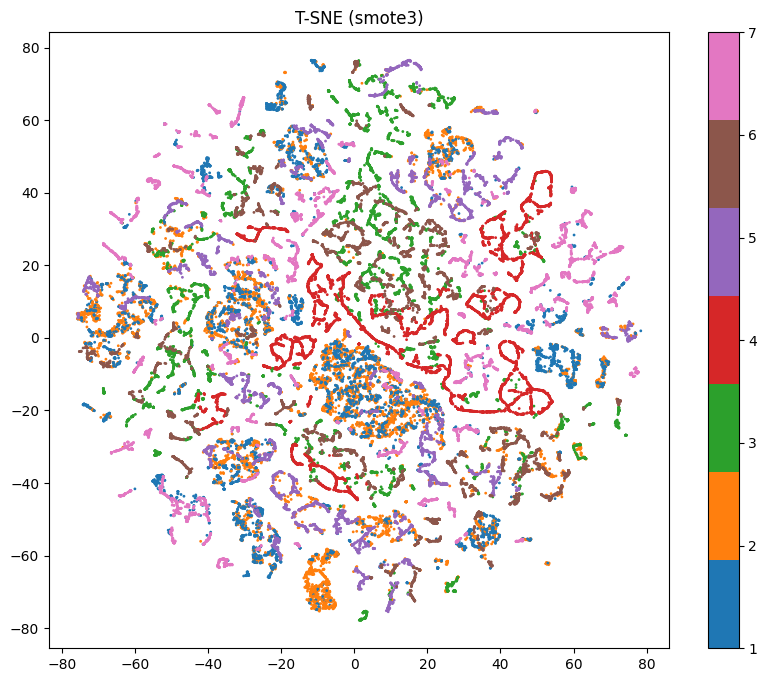

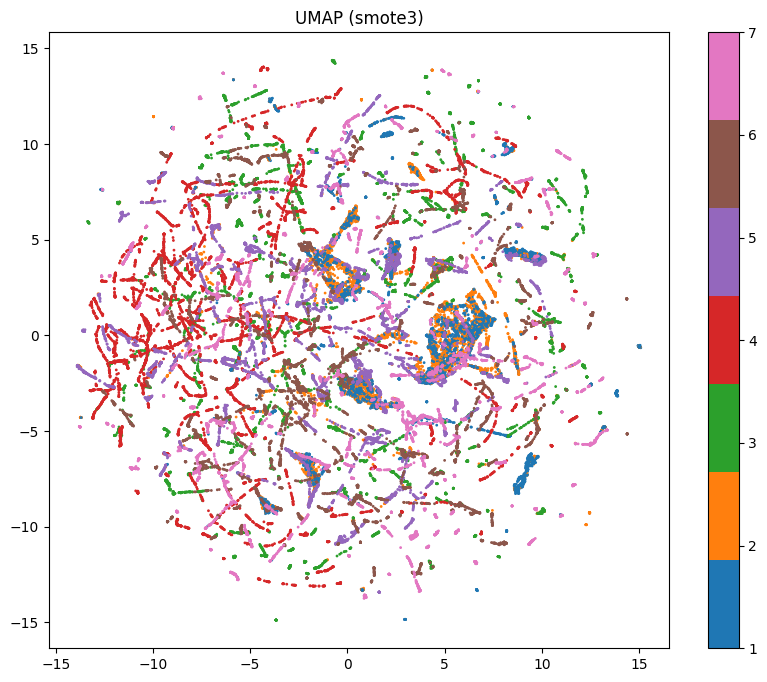

Accuracy: 0.7845
F1-Score: 0.7848

Rapport de classification:
              precision    recall  f1-score   support

           1       0.78      0.75      0.76      1459
           2       0.81      0.81      0.81      1930
           3       0.78      0.88      0.83       241
           4       0.55      0.67      0.60        18
           5       0.46      0.58      0.51        62
           6       0.71      0.72      0.72       133
           7       0.79      0.84      0.81       157

    accuracy                           0.78      4000
   macro avg       0.70      0.75      0.72      4000
weighted avg       0.79      0.78      0.78      4000



In [81]:
visualize_embeddings(X_tsne_smote3, y_train_smote3, "T-SNE (smote3)")
visualize_embeddings(X_umap_smote3, y_train_smote3, "UMAP (smote3)")
evaluate(rfc_smote3, X_test_scaled, y_test)

### smote5

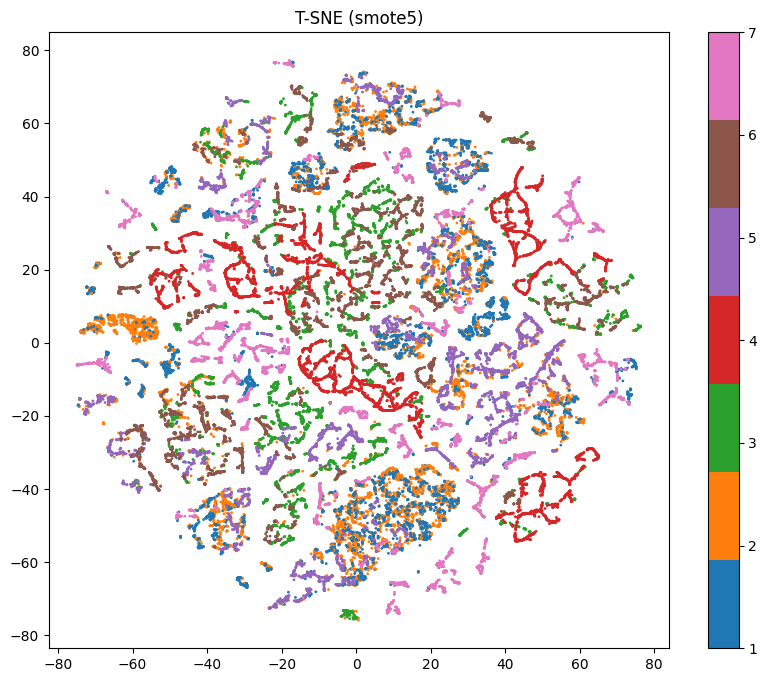

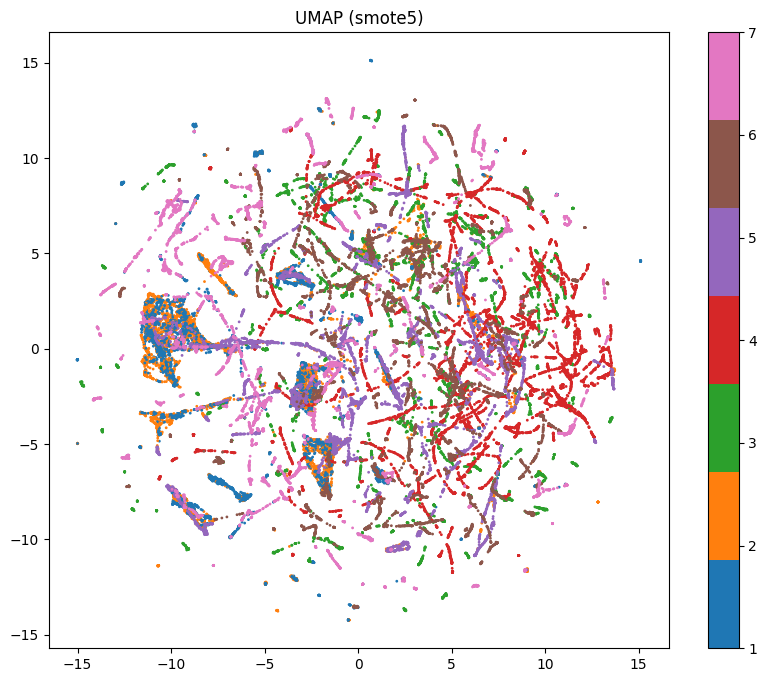

Accuracy: 0.7823
F1-Score: 0.7833

Rapport de classification:
              precision    recall  f1-score   support

           1       0.78      0.75      0.77      1459
           2       0.81      0.80      0.81      1930
           3       0.76      0.87      0.81       241
           4       0.63      0.67      0.65        18
           5       0.43      0.63      0.51        62
           6       0.65      0.73      0.69       133
           7       0.79      0.85      0.82       157

    accuracy                           0.78      4000
   macro avg       0.69      0.76      0.72      4000
weighted avg       0.79      0.78      0.78      4000



In [82]:
visualize_embeddings(X_tsne_smote5, y_train_smote5, "T-SNE (smote5)")
visualize_embeddings(X_umap_smote5, y_train_smote5, "UMAP (smote5)")
evaluate(rfc_smote5, X_test_scaled, y_test)

### Smote7

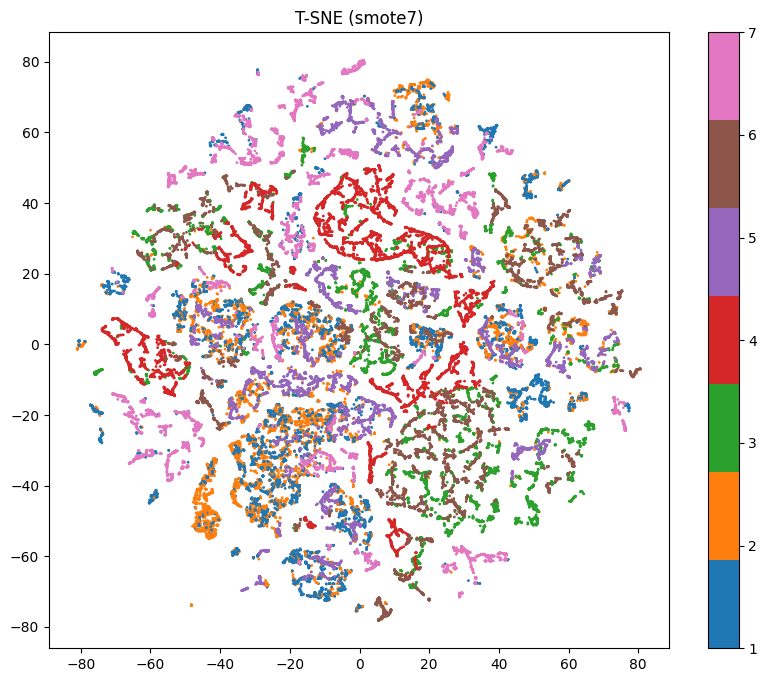

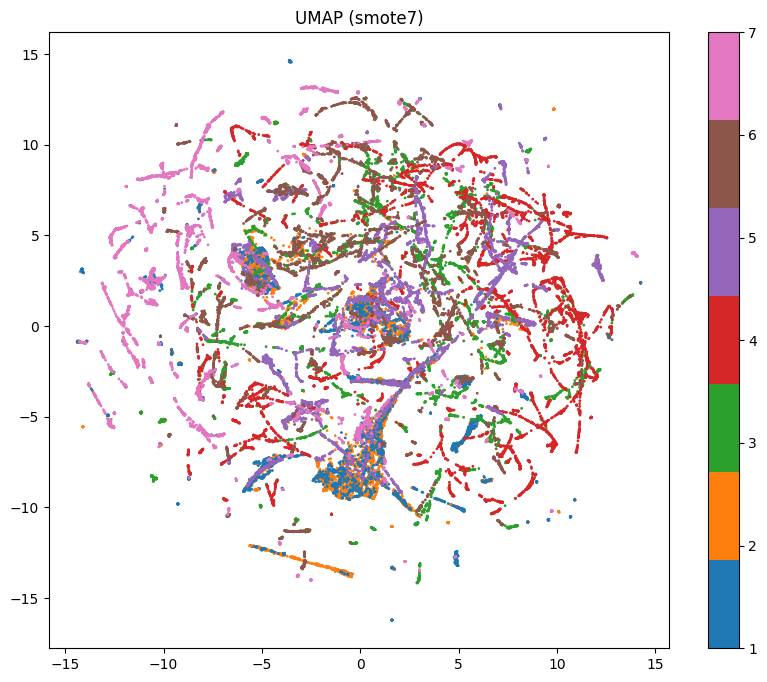

Accuracy: 0.7805
F1-Score: 0.7814

Rapport de classification:
              precision    recall  f1-score   support

           1       0.78      0.74      0.76      1459
           2       0.81      0.80      0.81      1930
           3       0.77      0.88      0.82       241
           4       0.58      0.61      0.59        18
           5       0.40      0.58      0.47        62
           6       0.66      0.74      0.70       133
           7       0.78      0.85      0.81       157

    accuracy                           0.78      4000
   macro avg       0.68      0.75      0.71      4000
weighted avg       0.78      0.78      0.78      4000



In [83]:
visualize_embeddings(X_tsne_smote7, y_train_smote7, "T-SNE (smote7)")
visualize_embeddings(X_umap_smote7, y_train_smote7, "UMAP (smote7)")
evaluate(rfc_smote7, X_test_scaled, y_test)